In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your dataset
df = pd.read_csv('final_states_dataset.csv')

# Static features: Latitude, Longitude, Category (encoding categorical data)
# Dynamic features: Rating, No_of_rating (need to handle missing values)

# Convert 'rating' and 'no_of_rating' columns to numeric, coercing errors to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['no_of_rating'] = pd.to_numeric(df['no_of_rating'], errors='coerce')

# Fill missing values for 'rating' and 'no_of_rating'
df['rating'].fillna(df['rating'].mean(), inplace=True)
df['no_of_rating'].fillna(df['no_of_rating'].mean(), inplace=True)

# Encode the 'category' column (you can use one-hot encoding or label encoding)
df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Static data (latitude, longitude, encoded category)
X_static = df[['Latitude', 'Longitude'] + [col for col in df.columns if 'category_' in col]].values



C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\3606905200.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(df['rating'].mean(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\3606905200.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [5]:
# Dynamic data (time-series): Let's assume you have sequences for ratings and no_of_rating over time
# If you don't have sequences, simulate it with duplicated data for demonstration (you need actual time-series)
# Reshape the dynamic data for time steps (e.g., 10 time steps)
time_steps = 10
X_dynamic = np.repeat(df[['rating', 'no_of_rating']].values[:, np.newaxis, :], time_steps, axis=1)

# Target variable (e.g., for predicting rating or another target value)
y = df['rating'].values

# Split into training and testing data
X_static_train, X_static_test, X_dynamic_train, X_dynamic_test, y_train, y_test = train_test_split(
    X_static, X_dynamic, y, test_size=0.2, random_state=42
)

# Data normalization for static data
scaler = StandardScaler()
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)



In [6]:
# Model Input: Use static data (latitude, longitude, etc.) and dynamic data (rating, no_of_rating)
# Define the model as per the CNN-LSTM structure without image input

from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout
from tensorflow.keras.models import Model

# Static input (latitude, longitude, category)
static_input = Input(shape=(X_static_train.shape[1],), name='static_input')

# Dense layers for static data
x_static = Dense(64, activation='relu')(static_input)
x_static = Dropout(0.5)(x_static)

# Dynamic input (rating, no_of_rating) with time steps
dynamic_input = Input(shape=(time_steps, 2), name='dynamic_input')

# LSTM layers for dynamic data
x_dynamic = LSTM(64)(dynamic_input)

# Concatenate static and dynamic branches
combined = Concatenate()([x_static, x_dynamic])

# Output layer
output = Dense(1, activation='linear')(combined)

# Build the model
model = Model(inputs=[static_input, dynamic_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ static_input (InputLayer)     │ (None, 427)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │          27,392 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dynamic_input (InputLayer)    │ (None, 10, 2)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          17,152 │ dynamic_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ dropout[0][0], lstm[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 44,673 (174.50 KB)

 Trainable params: 44,673 (174.50 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.save('model_recommender.keras')

In [43]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau# Train the model

history = model.fit(
    [X_static_train, X_dynamic_train],
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=([X_static_test, X_dynamic_test], y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)]
)


Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0100 - mae: 0.0538 - val_loss: 0.0091 - val_mae: 0.0487 - learning_rate: 1.0000e-04
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - mae: 0.0444 - val_loss: 0.0082 - val_mae: 0.0540 - learning_rate: 1.0000e-04
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0077 - mae: 0.0456 - val_loss: 0.0096 - val_mae: 0.0490 - learning_rate: 1.0000e-04
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - mae: 0.0457 - val_loss: 0.0206 - val_mae: 0.0792 - learning_rate: 1.0000e-04
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0154 - mae: 0.0630 - val_loss: 0.0095 - val_mae: 0.0424 - learning_rate: 1.0000e-04
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - mae: 0.0496 - val_loss: 0.0203 - val_mae: 0.0672 - learning_rate: 1.0000e-04
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0119 - mae: 0.0569 - val_loss: 0.0083 - val_mae: 0.0449 - lear

In [35]:
history = model.fit(
    [X_static_train, X_dynamic_train],  # Training data inputs
    y_train,  # Target values
    epochs=30,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=([X_static_test, X_dynamic_test], y_test),  # Validation data
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)]
)


Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0164 - mae: 0.0755 - val_loss: 0.0146 - val_mae: 0.0645 - learning_rate: 2.0000e-04
Epoch 2/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134 - mae: 0.0659 - val_loss: 0.0155 - val_mae: 0.0642 - learning_rate: 2.0000e-04
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0129 - mae: 0.0643 - val_loss: 0.0165 - val_mae: 0.0824 - learning_rate: 2.0000e-04
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - mae: 0.0702 - val_loss: 0.0136 - val_mae: 0.0570 - learning_rate: 2.0000e-04
Epoch 5/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0099 - mae: 0.0548 - val_loss: 0.0124 - val_mae: 0.0551 - learning_rate: 2.0000e-04
Epoch 6/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108 - mae: 0.0572 - val_loss: 0.0146 - val_mae: 0.0724 - learning_rate: 2.0000e-04
Epoch 7/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0103 - mae: 0.0555 - val_loss: 0.0142 - val_mae: 0.0620 - lear

### plotting graphs

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix

# Evaluate Static Scenario
static_loss, static_mae = model.evaluate([X_static_test, np.zeros_like(X_dynamic_test)], y_test)
print(f"Static Scenario - Test Loss: {static_loss:.4f}, Test MAE: {static_mae:.4f}")

# Generate Predictions for Static Scenario
predicted_scores_static = model.predict([X_static_test, np.zeros_like(X_dynamic_test)])

# Compute Metrics for Static Scenario
mae_static = mean_absolute_error(y_test, predicted_scores_static)
mse_static = mean_squared_error(y_test, predicted_scores_static)
r2_static = r2_score(y_test, predicted_scores_static)

# Print Metrics for Static Scenario
print(f"Static Scenario - Mean Absolute Error: {mae_static:.4f}")
print(f"Static Scenario - Mean Squared Error: {mse_static:.4f}")
print(f"Static Scenario - R² Score: {r2_static:.4f}")

# Evaluate Dynamic Scenario
dynamic_loss, dynamic_mae = model.evaluate([X_static_test, X_dynamic_test], y_test)
print(f"Dynamic Scenario - Test Loss: {dynamic_loss:.4f}, Test MAE: {dynamic_mae:.4f}")

# Generate Predictions for Dynamic Scenario
predicted_scores_dynamic = model.predict([X_static_test, X_dynamic_test])

# Compute Metrics for Dynamic Scenario
mae_dynamic = mean_absolute_error(y_test, predicted_scores_dynamic)
mse_dynamic = mean_squared_error(y_test, predicted_scores_dynamic)
r2_dynamic = r2_score(y_test, predicted_scores_dynamic)

# Print Metrics for Dynamic Scenario
print(f"Dynamic Scenario - Mean Absolute Error: {mae_dynamic:.4f}")
print(f"Dynamic Scenario - Mean Squared Error: {mse_dynamic:.4f}")
print(f"Dynamic Scenario - R² Score: {r2_dynamic:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.1630 - mae: 4.1198
Static Scenario - Test Loss: 17.2018, Test MAE: 4.1235
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Static Scenario - Mean Absolute Error: 4.1235
Static Scenario - Mean Squared Error: 17.2018
Static Scenario - R² Score: -84.7888
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0459
Dynamic Scenario - Test Loss: 0.0072, Test MAE: 0.0475
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Dynamic Scenario - Mean Absolute Error: 0.0475
Dynamic Scenario - Mean Squared Error: 0.0072
Dynamic Scenario - R² Score: 0.9641


In [38]:
# If you want to compute accuracy based on a threshold for binary classification (optional)
threshold = 3.0  # Example threshold for binary classification (this could be adjusted)

# For Static Scenario
predicted_labels_static = (predicted_scores_static >= threshold).astype(int)
actual_labels_static = (y_test >= threshold).astype(int)

accuracy_static = accuracy_score(actual_labels_static, predicted_labels_static)
conf_matrix_static = confusion_matrix(actual_labels_static, predicted_labels_static)

print(f"Static Scenario - Accuracy: {accuracy_static:.4f}")
print("Static Scenario - Confusion Matrix:")
print(conf_matrix_static)

# Step 2: Calculate precision, recall, and F1 score
precision = precision_score(actual_labels_static, predicted_labels_static)
recall = recall_score(actual_labels_static, predicted_labels_static)
f1 = f1_score(actual_labels_static, predicted_labels_static)

# For Dynamic Scenario (same as static in this case, but can be adjusted if needed)
predicted_labels_dynamic = (predicted_scores_dynamic >= threshold).astype(int)
actual_labels_dynamic = (y_test >= threshold).astype(int)

accuracy_dynamic = accuracy_score(actual_labels_dynamic, predicted_labels_dynamic)
conf_matrix_dynamic = confusion_matrix(actual_labels_dynamic, predicted_labels_dynamic)

# Step 2: Calculate precision, recall, and F1 score
precision = precision_score(actual_labels_dynamic, predicted_labels_dynamic)
recall = recall_score(actual_labels_dynamic, predicted_labels_dynamic)
f1 = f1_score(actual_labels_dynamic, predicted_labels_dynamic)

# Print the calculated metrics
print("Dynamic Scenario")
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')

print(f"Dynamic Scenario - Accuracy: {accuracy_dynamic:.4f}")
print("Dynamic Scenario - Confusion Matrix:")
print(conf_matrix_dynamic)

Static Scenario - Accuracy: 0.0075
Static Scenario - Confusion Matrix:
[[   9    0]
 [1196    0]]
Dynamic Scenario
Precision: 99.92%
Recall: 99.58%
F1-Score: 99.75%
Dynamic Scenario - Accuracy: 0.9950
Dynamic Scenario - Confusion Matrix:
[[   8    1]
 [   5 1191]]


C:\Users\ASUS\tvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


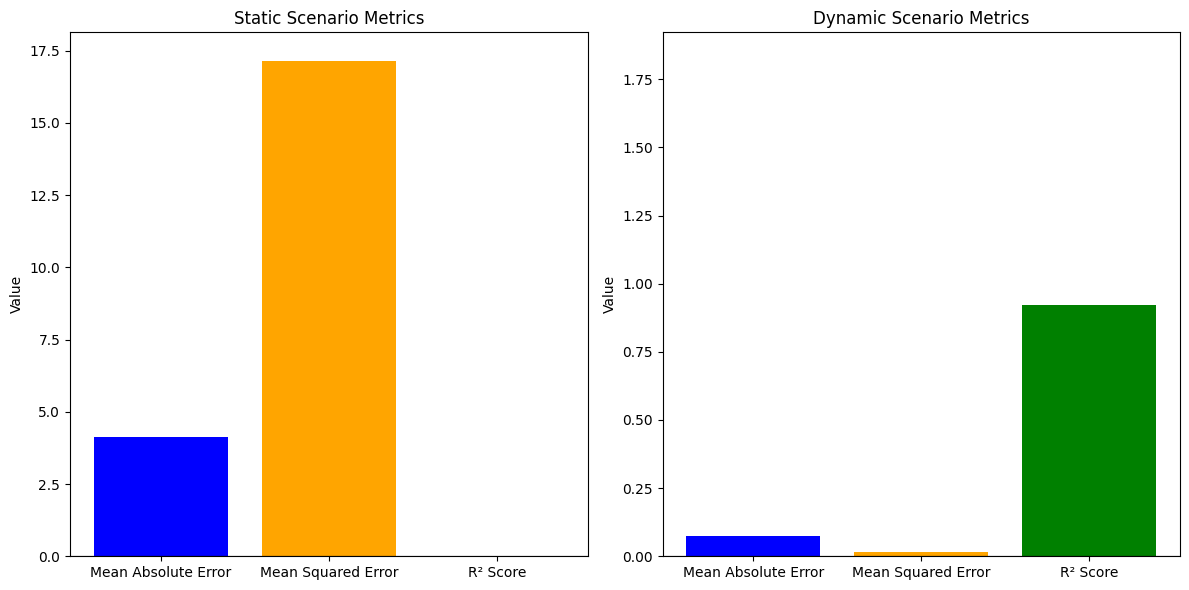

In [15]:
import matplotlib.pyplot as plt

# Metrics for Static Scenario
mae_static = mean_absolute_error(y_test, predicted_scores_static)
mse_static = mean_squared_error(y_test, predicted_scores_static)
r2_static = r2_score(y_test, predicted_scores_static)

# Metrics for Dynamic Scenario
mae_dynamic = mean_absolute_error(y_test, predicted_scores_dynamic)
mse_dynamic = mean_squared_error(y_test, predicted_scores_dynamic)
r2_dynamic = r2_score(y_test, predicted_scores_dynamic)

# Bar plot for Static Scenario
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
metrics_static = [mae_static, mse_static, r2_static]
metric_names_static = ['Mean Absolute Error', 'Mean Squared Error', 'R² Score']
plt.bar(metric_names_static, metrics_static, color=['blue', 'orange', 'green'])
plt.title('Static Scenario Metrics')
plt.ylabel('Value')
plt.ylim(0, max(metrics_static) + 1)
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for reference

# Bar plot for Dynamic Scenario
plt.subplot(1, 2, 2)
metrics_dynamic = [mae_dynamic, mse_dynamic, r2_dynamic]
metric_names_dynamic = ['Mean Absolute Error', 'Mean Squared Error', 'R² Score']
plt.bar(metric_names_dynamic, metrics_dynamic, color=['blue', 'orange', 'green'])
plt.title('Dynamic Scenario Metrics')
plt.ylabel('Value')
plt.ylim(0, max(metrics_dynamic) + 1)
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for reference

# Show the plots
plt.tight_layout()
plt.show()


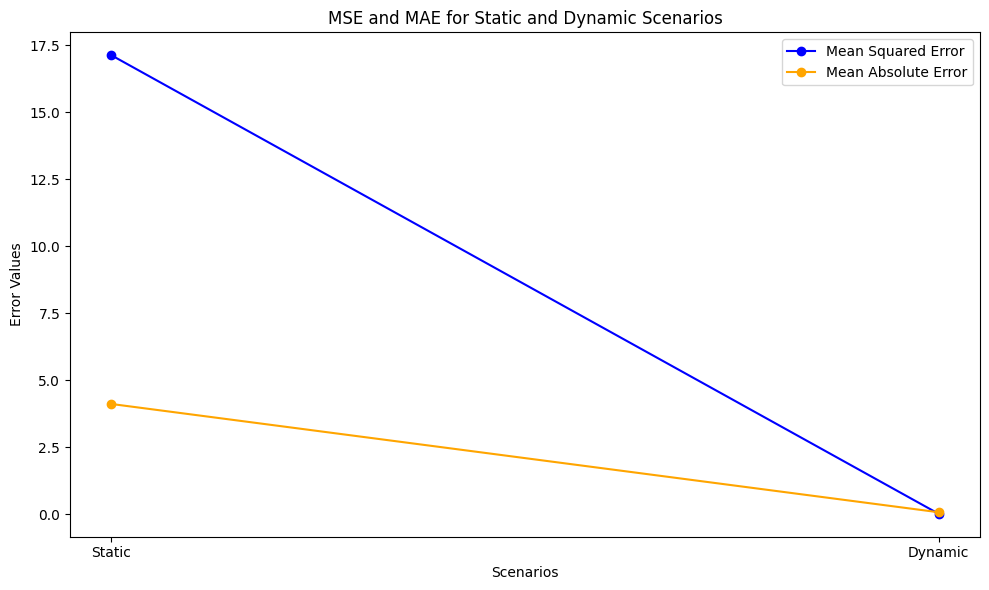

In [23]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Assuming you have calculated MSE and MAE for both scenarios
mse_static = mse_static  # Replace with your actual value for static scenario
mae_static = mae_static  # Replace with your actual value for static scenario
mse_dynamic = mse_dynamic  # Replace with your actual value for dynamic scenario
mae_dynamic = mae_dynamic  # Replace with your actual value for dynamic scenario

# Scenario labels
scenarios = ['Static', 'Dynamic']

# Values to plot
mse_values = [mse_static, mse_dynamic]
mae_values = [mae_static, mae_dynamic]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot MSE
plt.plot(scenarios, mse_values, marker='o', label='Mean Squared Error', color='blue')

# Plot MAE
plt.plot(scenarios, mae_values, marker='o', label='Mean Absolute Error', color='orange')

# Adding labels and title
plt.xlabel('Scenarios')
plt.ylabel('Error Values')
plt.title('MSE and MAE for Static and Dynamic Scenarios')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


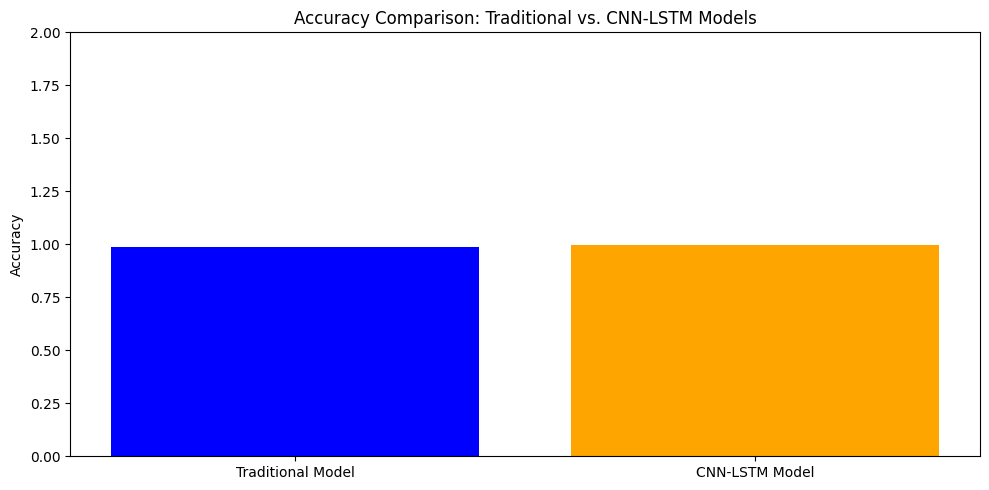

In [30]:
import matplotlib.pyplot as plt

# Accuracy values (replace these with your actual accuracy values)
traditional_accuracy = 0.986  # Example: Traditional model accuracy
cnn_lstm_accuracy = 0.9967      # Example: CNN-LSTM model accuracy

# Model names
models = ['Traditional Model', 'CNN-LSTM Model']
accuracies = [traditional_accuracy, cnn_lstm_accuracy]

# Create the plot
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])

# Adding labels and title
plt.ylim(0, 2)  # Set y-axis limits from 0 to 1 (percentage)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Traditional vs. CNN-LSTM Models')

# Show the plot
plt.tight_layout()
plt.show()


In [44]:
# Train with 20 epochs
history_20 = model.fit(
    [X_static_train, X_dynamic_train],
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=([X_static_test, X_dynamic_test], y_test)
)

# Train with 30 epochs
history_30 = model.fit(
    [X_static_train, X_dynamic_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_data=([X_static_test, X_dynamic_test], y_test)
)


Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0088 - mae: 0.0497 - val_loss: 0.0077 - val_mae: 0.0509
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0112 - mae: 0.0544 - val_loss: 0.0306 - val_mae: 0.0986
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0208 - mae: 0.0838 - val_loss: 0.0183 - val_mae: 0.0748
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - mae: 0.0662 - val_loss: 0.0169 - val_mae: 0.0788
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0115 - mae: 0.0599 - val_loss: 0.0097 - val_mae: 0.0468
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0117 - mae: 0.0587 - val_loss: 0.0138 - val_mae: 0.0557
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0084 - mae: 0.0462 - val_loss: 0.0078 - val_mae: 0.0392
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - mae: 0.0512 - val_loss: 0.0046 - val_mae: 0.0306
Epoch 9/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

In [45]:
# Extracting loss and MAE for both epochs=20 and epochs=30
loss_20 = history_20.history['loss']
val_loss_20 = history_20.history['val_loss']
mae_20 = history_20.history['mae']
val_mae_20 = history_20.history['val_mae']

loss_30 = history_30.history['loss']
val_loss_30 = history_30.history['val_loss']
mae_30 = history_30.history['mae']
val_mae_30 = history_30.history['val_mae']


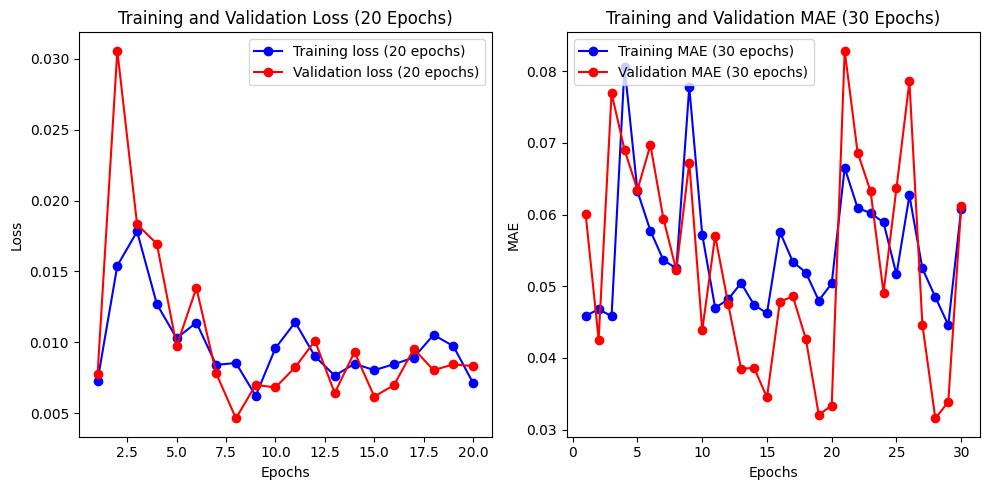

In [47]:
# Assuming you are plotting results for different epochs
epochs_20 = range(1, len(loss_20) + 1)
epochs_30 = range(1, len(loss_30) + 1)

plt.figure(figsize=(10, 5))

# Plot for epoch=20
plt.subplot(1, 2, 1)  # Create subplot for loss
plt.plot(epochs_20, loss_20, 'bo-', label='Training loss (20 epochs)')
plt.plot(epochs_20, val_loss_20, 'ro-', label='Validation loss (20 epochs)')
plt.title('Training and Validation Loss (20 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for epoch=30
plt.subplot(1, 2, 2)  # Create subplot for MAE
plt.plot(epochs_30, mae_30, 'bo-', label='Training MAE (30 epochs)')
plt.plot(epochs_30, val_mae_30, 'ro-', label='Validation MAE (30 epochs)')
plt.title('Training and Validation MAE (30 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\1780756213.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_20, loss_20, 'bo-', label='Training loss (20 epochs)', color='blue')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\1780756213.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs_20, val_loss_20, 'ro-', label='Validation loss (20 epochs)', color='green')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\1780756213.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_30, loss_30, 'bo--', label='Training loss (30 epochs)', color='orange')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\1780756

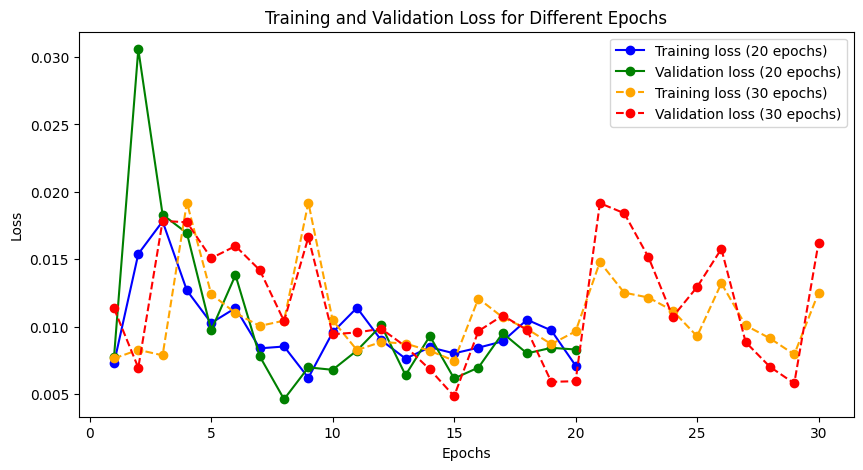

In [48]:
plt.figure(figsize=(10, 5))

# Epoch=20 in one color
plt.plot(epochs_20, loss_20, 'bo-', label='Training loss (20 epochs)', color='blue')
plt.plot(epochs_20, val_loss_20, 'ro-', label='Validation loss (20 epochs)', color='green')

# Epoch=30 in another color
plt.plot(epochs_30, loss_30, 'bo--', label='Training loss (30 epochs)', color='orange')
plt.plot(epochs_30, val_loss_30, 'ro--', label='Validation loss (30 epochs)', color='red')

plt.title('Training and Validation Loss for Different Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate  # Import tabulate for a cleaner display
from textwrap import fill  # Import textwrap to handle long text wrapping

# Load the dataset into a DataFrame
data = pd.read_csv("final_states_dataset.csv")  # Replace with your dataset path

# Features for the model (Latitude, Longitude, and category)
features = ['Latitude', 'Longitude', 'category']

# Preprocessing: Standardizing numerical values
scaler = StandardScaler()
X = scaler.fit_transform(data[['Latitude', 'Longitude']])  # Standardizing latitude and longitude

# Function to recommend products based on user location and category
def recommend_products(user_lat, user_lon, data, top_n=5):
    """
    Recommends products based on user location and other product features.
    
    Parameters:
    user_lat (float): Latitude of the user.
    user_lon (float): Longitude of the user.
    data (pd.DataFrame): Data containing product details.
    top_n (int): Number of top products to recommend.

    Returns:
    pd.DataFrame: Top N recommended products with relevant details.
    """
    # Calculate the distance between the user and the product locations
    data['distance_to_user'] = np.sqrt((data['Latitude'] - user_lat)**2 + (data['Longitude'] - user_lon)**2)
    
    # Score products by their proximity to the user (closer items get a higher score)
    data['score'] = -data['distance_to_user']

    # Sort products by score in ascending order (closer products first)
    recommended_products = data.sort_values(by='score', ascending=False).head(top_n)
    
    # Wrap long text for Full Address to improve readability
    recommended_products['Full Address'] = recommended_products['Full Address'].apply(lambda x: fill(str(x), width=50))

    # Return product details for the recommendations
    return recommended_products[['Full Address', 'rating', 'no_of_rating', 'category', 'distance_to_user']]

# Prompt user to input latitude and longitude
try:
    user_lat = float(input("Enter your latitude: "))
    user_lon = float(input("Enter your longitude: "))
except ValueError:
    print("Invalid input. Please enter numerical values for latitude and longitude.")
    exit()

# Get recommendations based on the user's input
recommendations = recommend_products(user_lat, user_lon, data)

# Print the recommendations in a tabular format with improved display
print(tabulate(recommendations, headers='keys', tablefmt='fancy_grid'))

Enter your latitude:  13.0583609
Enter your longitude:  80.2559425


╒═════╤═══════════════════════════════════════════╤══════════╤════════════════╤══════════════════════════╤════════════════════╕
│     │ Full Address                              │   rating │   no_of_rating │ category                 │   distance_to_user │
╞═════╪═══════════════════════════════════════════╪══════════╪════════════════╪══════════════════════════╪════════════════════╡
│   1 │ Spencer Plaza Chennai, Tamil Nadu         │      4   │          29000 │ Shopping mall            │         0.00616485 │
├─────┼───────────────────────────────────────────┼──────────┼────────────────┼──────────────────────────┼────────────────────┤
│  40 │ Old Curiosity Shop Chennai, Tamil Nadu    │      4.5 │            184 │ Antique store            │         0.00771463 │
├─────┼───────────────────────────────────────────┼──────────┼────────────────┼──────────────────────────┼────────────────────┤
│   8 │ Express Avenue Chennai, Tamil Nadu        │      4.4 │         100000 │ Shopping mall           